In [ ]:
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from IPython import get_ipython
from IPython import display
import torch
import random
import re
import collections
import inspect
import os
import hashlib # Added missing import
import zipfile # Added missing import
import tarfile # Added missing import
import requests # Import the requests library
from torch import nn
from torch.nn import functional as F

In [ ]:

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize']=figsize
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.

        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)


In [ ]:
class Module(nn.Module, HyperParameters):
    def __init__(self,plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board= ProgressBoard()
    def squared_loss(self,y_hat,y):
        return(y_hat-y.reshape(y_hat.shape))**2/2
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural Network is defined'
        return self.net(X)
    def plot(self, key, value, train):
        assert hasattr(self,'trainer'), 'Trainer is not inited'
        self.board.xlabel='epoch'
        if train:
            x= self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n=self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x=self.trainer.epoch+1
            n=self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        if isinstance(value, int):
            value=torch.tensor(value)
        self.board.draw(x,value.to('cpu').detach().numpy(), ('train_' if train else 'val_')+key, every_n=int(n))

    def training_step(self, batch):
        l=self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    def validation_step(self,batch):
        l=self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr=self.lr)
    def  apply_init(self, inputs, init=None):
        self.forward(inputs)
        if init is not None:
            self.net.apply(init)

In [ ]:
class DataModule(HyperParameters):
    def __init__(self, root='./data', num_workers=4):
        self.save_hyperparameters()
    def get_dataloader(self,train):
        i=slice(0,self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)


In [ ]:
def gpu(i=0):
    return torch.device(f'cuda:{i}')
def num_gpus():
    return torch.cuda.device_count()
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus_arg=0, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpus=[gpu(i) for i in range(min(num_gpus_arg, num_gpus()))]
    def prepare_data(self,data):
        self.train_dataloader=data.train_dataloader()
        self.val_dataloader=data.val_dataloader()
        self.num_train_batches=len(self.train_dataloader)
        self.num_val_batches=(len(self.val_dataloader) if self.val_dataloader is not None else 0)
    def prepare_model(self,model):
        model.trainer=self
        model.board.xlim=[0,self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model=model
    def fit(self,model,data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim=model.configure_optimizers()
        self.epoch=0
        self.train_batch_idx=0
        self.val_batch_idx=0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0: # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
    def prepare_batch(self,batch):
        if self.gpus:
            batch=[a.to(self.gpus[0]) for a in batch]
        return batch
    def clip_gradients(self, grad_clip_val, model):
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm



In [ ]:
class Classifier(Module):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
    def accuracy(Self, Y_hat, Y, averaged=True):
        Y_hat= Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds=Y_hat.argmax(axis=1).type(Y.dtype)
        compare=(preds==Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare
    def layer_summary(self,X_shape):
        X=torch.randn(*X_shape)
        for layer in self.net:
            X=layer(X)
            print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [ ]:
def download(url, folder='../data', sha1_hash=None):
    """Download a file to folder and return the local filepath."""
    if not url.startswith('http'):
    # For back compatability
        url, sha1_hash = DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
            sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def extract(filename, folder=None):
    """Extract a zip/tar file into folder."""
    base_dir = os.path.dirname(filename)
    _, ext = os.path.splitext(filename)
    assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files.'
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')
    else:
        fp = tarfile.open(filename, 'r')
    if folder is None:
        folder = base_dir
    fp.extractall(folder)

In [ ]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def cpu():
  """Get the CPU device."""
  return torch.device('cpu')
def try_gpu(i=0):
  if num_gpus() >= i + 1:
    return gpu(i)
  return cpu()

In [ ]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    use_svg_display()
    num_rows, num_cols, _, _ =matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

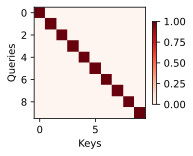

In [ ]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [ ]:
def gaussian(x):
  return torch.exp(-x**2/2)
def boxcar(x):
  return torch.abs(x)<1
def constant(x):
  return 1+0*x
def epanechikov(x):
  return torch.max(1-torch.abs(x),torch.zeros_like(x))

In [ ]:
import numpy as np

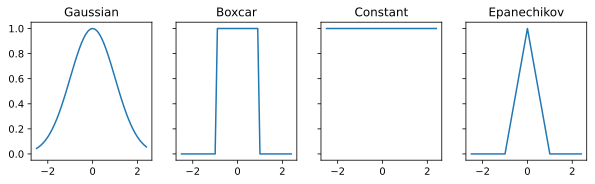

In [ ]:
fig, axes = plt.subplots(1, 4, sharey= True, figsize=(10, 2.5))
kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x=torch.arange(-2.5,2.5,0.1)
for kernel, name, ax in zip (kernels, names, axes):
  ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
  ax.set_title(name)
plt.show()

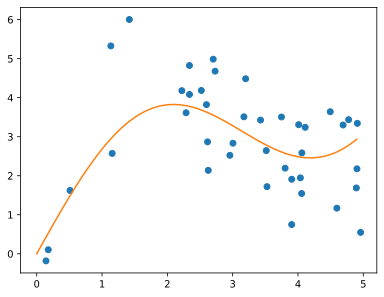

In [ ]:
def f(x):
  return 2*torch.sin(x)+x
n=40
x_train, _=torch.sort(torch.rand(n)*5)
y_train =f(x_train)+torch.randn(n)
x_val=torch.arange(0,5,0.1)
y_val=f(x_val)
plt.plot(x_train.detach().numpy(), y_train.detach().numpy(), 'o')
plt.plot(x_val.detach().numpy(), y_val.detach().numpy())
plt.show()

In [ ]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1,1)) - x_val.reshape((1,-1))
    k=kernel(dists).type(torch.float32)
    attention_w =k/k.sum(0)
    y_hat=y_train@attention_w
    return y_hat, attention_w


In [ ]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention =False):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(10, 2.5))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm=ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5)
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)


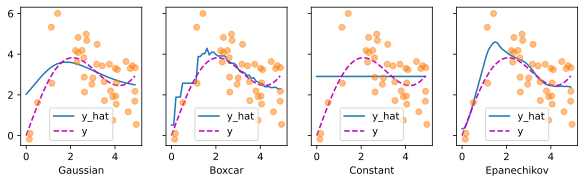

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names)

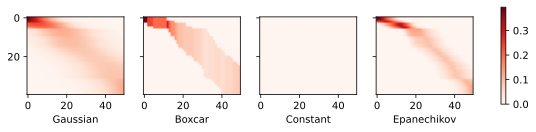

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

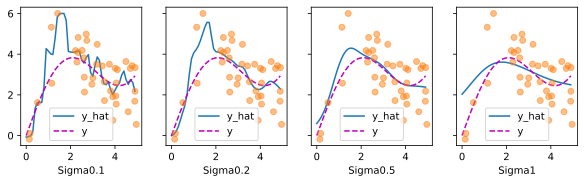

In [ ]:
sigmas=(0.1, 0.2, 0.5,1)
names=['Sigma'+str(sigma) for sigma in sigmas]
def gaussian_with_weight(sigma):
  return (lambda x: torch.exp(-x**2/(2*sigma**2)))

kernels=[gaussian_with_weight(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

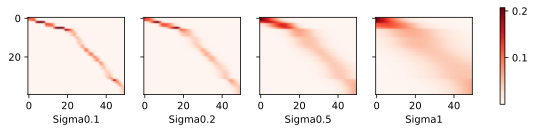

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)